In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

from src.rl_env import CreditLimitEnv
from src.dqn import DQNTrainer
from src.evaluation import EvaluationUtils

=== RL Pipeline Started ===
[INFO] Loading dataset...
[INFO] Loaded 40,406 rows.
[INFO] Applying stratified sampling...
[INFO] Sampled shape: (4041, 14)
[INFO] Initializing environment...
State space: ['BALANCE_CLASS', 'UR', 'PR', 'D_PROVISION_bin'] | Action space: [0, 1]
Sample size: 4041
[INFO] No saved model found. Will train from scratch.
[INFO] Training new model...


Training Episodes: 100%|██████████| 10/10 [01:50<00:00, 11.04s/it]



Training complete in 1.84 minutes
Best Episode Reward : 350.36584162976203
Final Action Count   : {0: 10765, 1: 9959}


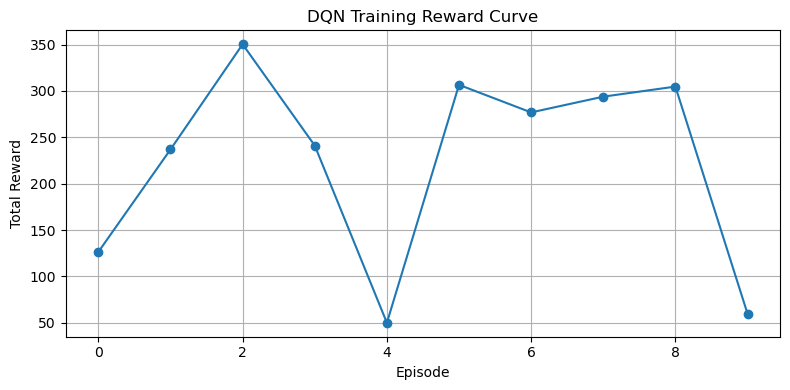

[INFO] Evaluating RL Agent and Benchmarks...

=== Simulated Rewards ===
RL Agent         : 136.5859
Random           : 226.1638
Never Increase   : 297.9923
Always Increase  : 148.5451

=== Real (Ground-Truth) Rewards ===
RL Agent         : 147.8474
Random           : 242.4736
Never Increase   : 319.2908
Always Increase  : 160.5520


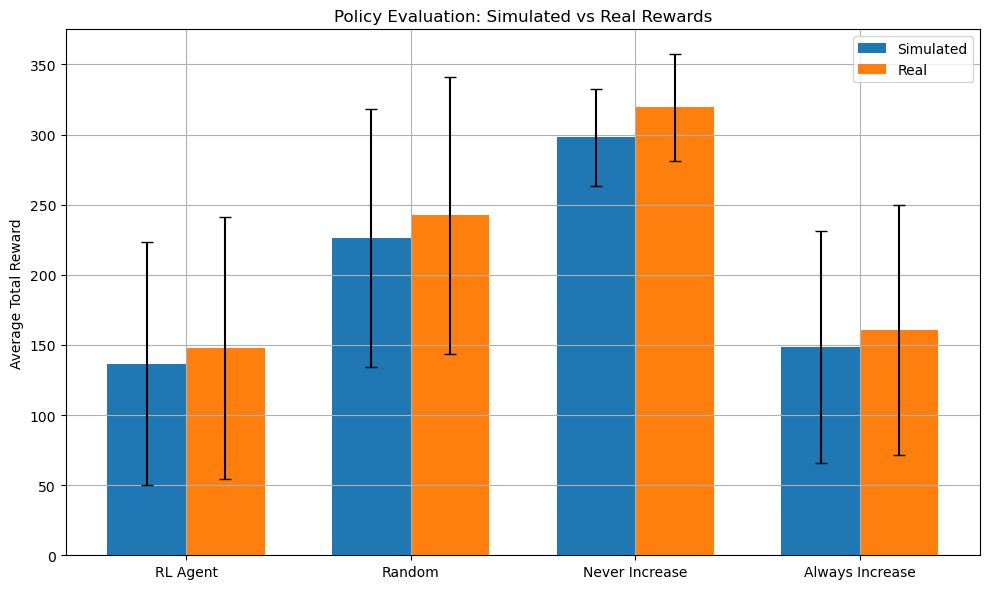

=== RL Pipeline Completed ===


In [2]:
# === CONFIG ===
DEBUG_MODE = True
SAMPLE_FRAC = 0.1
EPISODES = 10 if DEBUG_MODE else 500
N_RUNS = 3 if DEBUG_MODE else 20
DATA_PATH = "data/processed/cleaned_df.csv"
MODEL_PATH = None if DEBUG_MODE else "models/best_dqn_model.pth"

print("=== RL Pipeline Started ===")

# === Step 1: Load dataset ===
print("[INFO] Loading dataset...")
full_df = pd.read_csv(DATA_PATH)
print(f"[INFO] Loaded {len(full_df):,} rows.")

# === Step 2: Stratified sample if debugging ===
if DEBUG_MODE:
    print("[INFO] Applying stratified sampling...")
    full_df["STRATA"] = full_df["BALANCE_CLASS"].astype(str) + "_" + full_df["D_PROVISION_bin"].astype(str)
    sampled_df = (
        full_df.groupby("STRATA", group_keys=False)
        .apply(lambda x: x.sample(frac=SAMPLE_FRAC, random_state=42))
        .reset_index(drop=True)
    )
    final_df = sampled_df.drop(columns=["STRATA"])
    print(f"[INFO] Sampled shape: {final_df.shape}")
else:
    final_df = full_df

# === Step 3: Set global provision bins & initialize env ===
provision_bins = np.arange(-0.5, 1.51, 0.01)
globals()["provision_bins"] = provision_bins

print("[INFO] Initializing environment...")
env = CreditLimitEnv(final_df, provision_bins=provision_bins)
print(f"State space: {env.state_space} | Action space: {env.action_space}")
print(f"Sample size: {env.n_customers}")

# === Step 4: Train or Load Model ===
trainer = DQNTrainer(env, model_path=MODEL_PATH)
model = trainer.policy_net
reward_history = None

if not trainer.pretrained_loaded:
    print("[INFO] Training new model...")
    model, _, reward_history, _ = trainer.train(episodes=EPISODES)

# === Step 5: Plot training reward history ===
if reward_history is not None and len(reward_history) > 0:
    EvaluationUtils.plot_training_reward_history(reward_history)

# === Step 6: Wrap agent ===
agent = EvaluationUtils.DQNAgent(model, env.action_space)

# === Step 7: Evaluate policies ===
print("[INFO] Evaluating RL Agent and Benchmarks...")
rl_sim, rl_real     = EvaluationUtils.evaluate_policy(agent, env, n_runs=N_RUNS)
rand_sim, rand_real = EvaluationUtils.evaluate_policy(None, env, n_runs=N_RUNS, benchmark="random")
no_sim, no_real     = EvaluationUtils.evaluate_policy(None, env, n_runs=N_RUNS, benchmark="never_increase")
all_sim, all_real   = EvaluationUtils.evaluate_policy(None, env, n_runs=N_RUNS, benchmark="always_increase")

# === Step 8: Package results ===
sim_results = {
    "RL Agent": rl_sim,
    "Random": rand_sim,
    "Never Increase": no_sim,
    "Always Increase": all_sim
}

real_results = {
    "RL Agent": rl_real,
    "Random": rand_real,
    "Never Increase": no_real,
    "Always Increase": all_real
}

# === Step 9: Print summaries ===
print("\n=== Simulated Rewards ===")
for name, rewards in sim_results.items():
    print(f"{name:17s}: {np.mean(rewards):.4f}")

print("\n=== Real (Ground-Truth) Rewards ===")
for name, rewards in real_results.items():
    print(f"{name:17s}: {np.mean(rewards):.4f}")

# === Step 10: Plot comparisons ===
EvaluationUtils.plot_policy_comparison(sim_results, real_results)

print("=== RL Pipeline Completed ===")